<a href="https://colab.research.google.com/github/wilberquito/AMLProject/blob/main/notebooks/Resnet101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resnet101

In [1]:
import zipfile
from pathlib import Path
import torch
import matplotlib.pyplot as plt

In [2]:
try:
    import google.colab
    IN_COLAB = True
    ! pip install torchvision
    ! pip install torchinfo
except:
    IN_COLAB = False

In [4]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    !rm -rf data
    data_path = Path('/content/drive/MyDrive/AML/dataset_CIFAR10.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall("data")

    !rm -rf modular
    data_path = Path('/content/drive/MyDrive/AML/modular.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall(".")

    !rm -rf trained
    !cp -rf /content/drive/MyDrive/AML/trained ./trained

Mounted at /content/drive


## Show device available

In [ ]:
'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

## Show model arquitecture

In [ ]:
from torchinfo import summary
import modular.models as models
from prettytable import PrettyTable

In [ ]:
amlresnet101 = models.AMLResnet101(out_dim=10)

In [ ]:
batch_size = 16
img_size = 232
summary(model=amlresnet101, 
        input_size=(32, 3, img_size, img_size),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
AMLResnet101 (AMLResnet101)                   [32, 3, 232, 232]    [32, 10]             --                   Partial
├─ResNet (net)                                [32, 3, 232, 232]    [32, 2048]           --                   False
│    └─Conv2d (conv1)                         [32, 3, 232, 232]    [32, 64, 116, 116]   (9,408)              False
│    └─BatchNorm2d (bn1)                      [32, 64, 116, 116]   [32, 64, 116, 116]   (128)                False
│    └─ReLU (relu)                            [32, 64, 116, 116]   [32, 64, 116, 116]   --                   --
│    └─MaxPool2d (maxpool)                    [32, 64, 116, 116]   [32, 64, 58, 58]     --                   --
│    └─Sequential (layer1)                    [32, 64, 58, 58]     [32, 256, 58, 58]    --                   False
│    │    └─Bottleneck (0)                    [32, 64, 58, 58]     [32, 256, 58,

In [ ]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
_ = count_parameters(amlresnet101)

+-------------+------------+
|   Modules   | Parameters |
+-------------+------------+
| fc.1.weight |    2048    |
|  fc.1.bias  |    2048    |
| fc.3.weight |  1048576   |
|  fc.3.bias  |    512     |
| fc.5.weight |    512     |
|  fc.5.bias  |    512     |
| fc.7.weight |    5120    |
|  fc.7.bias  |     10     |
+-------------+------------+
Total Trainable Params: 1059338


## Fine tunning

In [ ]:
import torch
import modular.datasets as datasets
import modular.models as models 
from pathlib import Path
from modular.engine import train
import torchvision.transforms as transforms
from modular.utils import set_seeds

set_seeds(seed=42)

# Model
amlresnet101 = models.AMLResnet101(out_dim=10)
# Let base train
amlresnet101.unfreeze_base()

train_transforms, validate_transforms = amlresnet101.transforms, amlresnet101.transforms

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomPerspective(),
])

train_transforms = transforms.Compose([augmentation, train_transforms])

# Optimizer
lr = 0.001
optimizer = torch.optim.Adam(params=amlresnet101.parameters(),
                             lr=lr)

# Criterion
criterion = torch.nn.CrossEntropyLoss()

# Number of epochs to train the model
epochs = 3

# Default device to train model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Where the model is saved
save_as = Path('finetune.amlresnet101.pth')

# Mini batch
batch_size=100

train_dataloader = datasets.get_dataloader(folder_root='data/train',
                                           transformer=train_transforms,
                                           batch_size=batch_size,
                                           suffle=True)
validate_dataloader = datasets.get_dataloader(folder_root='data/validation',
                                           transformer=validate_transforms,
                                           batch_size=batch_size,
                                           suffle=False)

In [ ]:
results = train(model=amlresnet101,
                train_dataloader=train_dataloader,
                test_dataloader=validate_dataloader,
                optimizer=optimizer,
                criterion=criterion,
                epochs=epochs,
                device=device,
                save_as=save_as)

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | train_loss: 1.0291 | train_acc: 0.6461 | test_loss: 0.6303 | test_acc: 0.7865


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 2 | train_loss: 0.6969 | train_acc: 0.7618 | test_loss: 0.5463 | test_acc: 0.8110


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 3 | train_loss: 0.6168 | train_acc: 0.7886 | test_loss: 0.5041 | test_acc: 0.8246


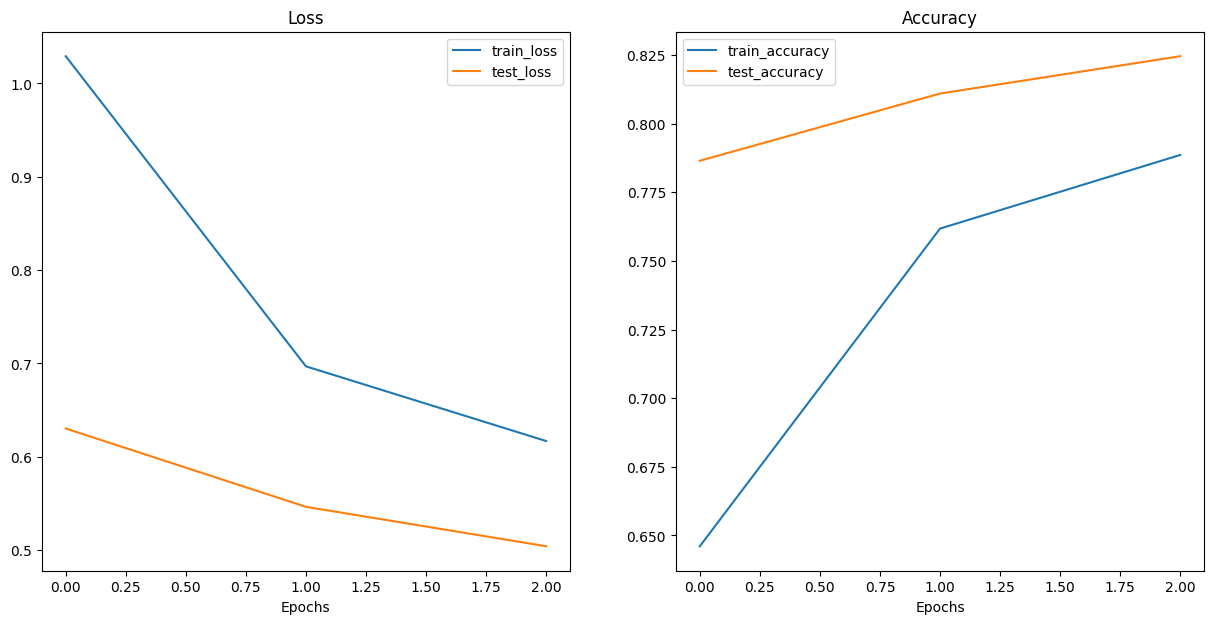

In [ ]:
from modular.utils import plot_loss_curves
plot_loss_curves(results)

In [ ]:
if IN_COLAB:
  from google.colab import files
  files.download('finetune.amlresnet101.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Training find tunning AMLResnet101

In [1]:
try:
    import google.colab
    IN_COLAB = True
    ! pip install torchvision
    ! pip install torchinfo
except:
    IN_COLAB = False

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
from pathlib import Path

saved_data = torch.load(Path('trained/finetune.amlresnet101.pth'))
saved_data.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc', 'epoch', 'optimizer', 'model'])

In [3]:
import torch
import modular.datasets as datasets
import modular.models as models 
from pathlib import Path
from modular.engine import train
import torchvision.transforms as transforms
from modular.utils import set_seeds

set_seeds(seed=42)

# Model
amlresnet101 = models.AMLResnet101(out_dim=10)
# Recover state dict
state_dict = saved_data['model']
# Load saved state dict into the model
amlresnet101.load_state_dict(state_dict)
# Freeze base
amlresnet101.freeze_base()

train_transforms, validate_transforms = amlresnet101.transforms, amlresnet101.transforms

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomPerspective(),
])

train_transforms = transforms.Compose([augmentation, train_transforms])

# Optimizer
lr = 0.001
optimizer = torch.optim.Adam(params=amlresnet101.parameters(),
                             lr=lr)

# Criterion
criterion = torch.nn.CrossEntropyLoss()

# Number of epochs to train the model
epochs = 10

# Default device to train model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Where the model is saved
save_as = Path('trained/amlresnet101.pth')

# Mini batch
batch_size=750

train_dataloader = datasets.get_dataloader(folder_root='data/train',
                                           transformer=train_transforms,
                                           batch_size=batch_size,
                                           suffle=True)
validate_dataloader = datasets.get_dataloader(folder_root='data/validation',
                                           transformer=validate_transforms,
                                           batch_size=batch_size,
                                           suffle=False)

In [ ]:
results = train(model=amlresnet101,
                train_dataloader=train_dataloader,
                test_dataloader=validate_dataloader,
                optimizer=optimizer,
                criterion=criterion,
                epochs=epochs,
                device=device,
                save_as=save_as)

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [ ]:
from modular.utils import plot_loss_curves
plot_loss_curves(results)

In [ ]:
if IN_COLAB:
  from google.colab import files
  files.download('finetune.amlresnet101.pth')